# Creation of our CNN model

## Import functions

In [ ]:
import os
import random
import pandas as pd
import re
import string
from nltk.corpus import stopwords

import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Test connexion dataset Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"antodar","key":"799a4df7cc87af987797c50798a090af"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Jan  9 06:12 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bryanpark/french-single-speaker-speech-dataset

100% 5.58G/5.58G [00:46<00:00, 202MB/s]
100% 5.58G/5.58G [00:46<00:00, 130MB/s]


In [ ]:
! unzip french-single-speaker-speech-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: lesmis/lesmis_3651.wav  
  inflating: lesmis/lesmis_3652.wav  
  inflating: lesmis/lesmis_3653.wav  
  inflating: lesmis/lesmis_3654.wav  
  inflating: lesmis/lesmis_3655.wav  
  inflating: lesmis/lesmis_3656.wav  
  inflating: lesmis/lesmis_3657.wav  
  inflating: lesmis/lesmis_3658.wav  
  inflating: lesmis/lesmis_3659.wav  
  inflating: lesmis/lesmis_3660.wav  
  inflating: lesmis/lesmis_3661.wav  
  inflating: lesmis/lesmis_3662.wav  
  inflating: lesmis/lesmis_3663.wav  
  inflating: lesmis/lesmis_3664.wav  
  inflating: lesmis/lesmis_3665.wav  
  inflating: lesmis/lesmis_3666.wav  
  inflating: lesmis/lesmis_3667.wav  
  inflating: lesmis/lesmis_3668.wav  
  inflating: lesmis/lesmis_3669.wav  
  inflating: lesmis/lesmis_3670.wav  
  inflating: lesmis/lesmis_3671.wav  
  inflating: lesmis/lesmis_3672.wav  
  inflating: lesmis/lesmis_3673.wav  
  inflating: lesmis/lesmis_3674.wav  
  inflatin

## WER definition

In [ ]:
def wer(ref, hyp ,debug=True):
    r = ref.split()
    h = hyp.split()
    #costs will holds the costs, like in the Levenshtein distance algorithm
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    # backtrace will hold the operations we've done.
    # so we could later backtrace, like the WER algorithm requires us to.
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
 
    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3
    DEL_PENALTY = 1
    INS_PENALTY = 1
    SUB_PENALTY = 1
    
    # First column represents the case where we achieve zero
    # hypothesis words by deleting all reference words.
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL
    
    # First row represents the case where we achieve the hypothesis
    # by inserting all hypothesis words into a zero-length reference.
    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS
    
    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY # penalty is always 1
                insertionCost    = costs[i][j-1] + INS_PENALTY   # penalty is always 1
                deletionCost     = costs[i-1][j] + DEL_PENALTY   # penalty is always 1
                 
                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL
                 
    # back trace though the best route:
    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    if debug:
        print("OP\tREF\tHYP")
        lines = []
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
            if debug:
                lines.append("OK\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
            if debug:
                lines.append("SUB\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
            if debug:
                lines.append("INS\t" + "****" + "\t" + h[j])
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
            if debug:
                lines.append("DEL\t" + r[i]+"\t"+"****")
    if debug:
        lines = reversed(lines)
        for line in lines:
            print(line)
        print("#cor " + str(numCor))
        print("#sub " + str(numSub))
        print("#del " + str(numDel))
        print("#ins " + str(numIns))
    wer_result = round( (numSub + numDel + numIns) / (float) (len(r)), 3)
    return {'WER':wer_result, 'numCor':numCor, 'numSub':numSub, 'numIns':numIns, 'numDel':numDel, "numCount": len(r)}

def wers(refs, hyps):
    numSub = 0
    numDel = 0
    numCor = 0
    numIns = 0
    numCount = 0
    for ref, hyp in zip(refs, hyps):
        result = wer(ref, hyp, False)
        numSub += result["numSub"]
        numDel += result["numDel"]
        numCor += result["numCor"]
        numIns += result["numIns"]
        numCount += result["numCount"]
 
    return round( (numSub + numDel + numIns) / (float) (numCount), 3)

## Compute Neural Network

### Data preparation

In [ ]:
df_text = pd.read_csv('/content/transcript.txt', sep='|', header=None)
df_text = df_text.iloc[:,:2]
df_text.columns = ['file', 'transcription']
df_text.head()

,file,transcription
0,lesmis/lesmis_0001.wav,Chapitre I La Charybde du faubourg Saint-Antoi...
1,lesmis/lesmis_0002.wav,Les deux plus mémorables barricades que l'obse...
2,lesmis/lesmis_0003.wav,"Ces deux barricades, symboles toutes les deux,..."
3,lesmis/lesmis_0004.wav,sortirent de terre lors de la fatale insurrect...
4,lesmis/lesmis_0005.wav,"Il arrive quelquefois que, même contre les pri..."


In [ ]:
#remove punctuations...
punct = list(string.punctuation)
df_text["transcription"] = df_text["transcription"].apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
df_text["transcription"] = df_text["transcription"].apply(lambda x: x.replace("[^A-Za-z]",""))
df_text['transcription'] = df_text['transcription'].apply(lambda x: " ".join([word for word in x.split() if word not in punct]))
df_text["transcription"] = df_text["transcription"].apply(lambda x: x.replace("'",""))
df_text["transcription"] = df_text["transcription"].apply(lambda x: x.lower())
df_text["transcription"] = df_text["transcription"].apply(lambda x: x.replace("\s+"," "))
df_text['transcription'] = "start "+df_text['transcription']+" end"
df_text.head()

,file,transcription
0,lesmis/lesmis_0001.wav,start chapitre i la charybde du faubourg saint...
1,lesmis/lesmis_0002.wav,start les deux plus m morables barricades que ...
2,lesmis/lesmis_0003.wav,start ces deux barricades symboles toutes les ...
3,lesmis/lesmis_0004.wav,start sortirent de terre lors de la fatale ins...
4,lesmis/lesmis_0005.wav,start il arrive quelquefois que m me contre le...


In [ ]:
df_text = df_text.sample(2000,random_state = 0)

In [ ]:
df_text.shape

(2000, 2)

In [ ]:
df_text.head()

,file,transcription
7913,lupincontresholme/lupincontresholme_2419.wav,start videmment mais comment pouvait il la con...
1811,lesmis/lesmis_1812.wav,start il r alise presque l id al de ce qu on e...
4923,lesmis/lesmis_4924.wav,start cet argent est bien toi voici toute la c...
4695,lesmis/lesmis_4696.wav,start toute sa vie se concentrait dans cette h...
7159,lupincontresholme/lupincontresholme_1665.wav,start deux heures je pourrai moi m me quitter ...


### Compute MFCC features

In [ ]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x , sr = librosa.load(path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs

In [ ]:
mfcc_features = {}
for audio_path in df_text['file'].values:
    audio_path = "/content/"+audio_path
    path = audio_path.split('/')[-1]
    mfcc_features[path] = create_mfcc_features(audio_path)

In [ ]:
sentences = df_text['transcription'].to_list()
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
print(sequences)

[[1, 687, 50, 145, 172, 8, 4, 806, 51, 688, 32, 14, 7, 460, 18, 59, 36, 38, 108, 5, 7, 29, 1276, 319, 3, 49, 604, 2], [1, 8, 38, 2812, 173, 5, 197, 295, 3, 19, 28, 30, 2813, 15, 1013, 46, 7, 226, 2814, 8, 14, 2815, 6, 2816, 51, 2], [1, 94, 461, 14, 73, 530, 531, 146, 4, 105, 7, 1277, 1278, 462, 3, 2817, 532, 2], [1, 146, 53, 147, 27, 2818, 21, 49, 153, 5, 8, 10, 2819, 64, 10, 9, 47, 2], [1, 57, 203, 33, 2820, 74, 29, 35, 1014, 4, 351, 110, 10, 111, 1279, 12, 1015, 2821, 3, 379, 1756, 19, 18, 22, 14, 23, 17, 189, 380, 2], [1, 7, 533, 10, 26, 2822, 7, 1757, 34, 1758, 5, 116, 10, 26, 534, 15, 2823, 463, 30, 20, 381, 48, 7, 1280, 2], [1, 32, 14, 83, 807, 33, 605, 43, 28, 11, 2824, 127, 262, 80, 10, 6, 106, 20, 68, 14, 17, 105, 38, 2825, 37, 9, 1016, 2], [1, 102, 8, 27, 2826, 181, 7, 2827, 808, 8, 606, 12, 1759, 382, 29, 1281, 45, 62, 809, 2], [1, 167, 26, 94, 425, 154, 1017, 84, 2828, 84, 1282, 2829, 6, 84, 24, 2830, 8, 103, 464, 296, 174, 70, 2], [1, 102, 47, 1760, 87, 5, 198, 18, 204, 17

### Definition model inputs

In [ ]:
def get_model_input(df):
    X_feature, X_seq, y = list(), list(), list()
    audio_files = df_text['file'].tolist()

    for audio_file in audio_files:
        path = audio_file.split('/')[-1]
        feature = mfcc_features[path].reshape(16, 8, 1)
        captions = df_text.loc[df_text['file']==audio_file, 'transcription'].tolist()
        for caption in captions:
            sequence = tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(sequence)):
                in_sequence, out_sequence = sequence[:i], sequence[i]
                in_sequence = tf.keras.preprocessing.sequence.pad_sequences([in_sequence], maxlen=max_length)[0]
                out_sequence = tf.keras.utils.to_categorical([out_sequence], num_classes=vocab_size)[0]
                X_feature.append(feature)
                X_seq.append(in_sequence)
                y.append(out_sequence)

    X_feature, X_seq, y = np.array(X_feature), np.array(X_seq), np.array(y)
    return X_feature, X_seq, y

In [ ]:
train, test = train_test_split(df_text, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape, test.shape)
print(vocab_size)
print(max_length)

(1600, 2) (400, 2)
6493
59


In [ ]:
train_feature, train_seq, train_y = get_model_input(train)
test_feature, test_seq, test_y = get_model_input(test)

train_feature.shape, train_seq.shape, train_y.shape

((45120, 16, 8, 1), (45120, 59), (45120, 6493))

In [ ]:
test_feature.shape, test_seq.shape, test_y.shape

((45120, 16, 8, 1), (45120, 59), (45120, 6493))

In [ ]:
train_seq = train_seq.reshape(45120,59)
train_y = train_y.reshape(45120,6493)
test_seq = test_seq.reshape(45120,59)
test_y = test_y.reshape(45120,6493)

In [ ]:
tr = pd.DataFrame({"train_feature": list(train_feature),"train_seq":list(train_seq),"train_y":list(train_y)})

In [ ]:
tr.head()

,train_feature,train_seq,train_y
0,"[[[-364.39444], [89.56986], [-9.885267], [30.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[[-364.39444], [89.56986], [-9.885267], [30.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[-364.39444], [89.56986], [-9.885267], [30.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[-364.39444], [89.56986], [-9.885267], [30.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[-364.39444], [89.56986], [-9.885267], [30.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = strategy.num_replicas_in_sync * 4
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 16
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")     

Running on 1 replicas
Batch Size: 16


### Creation of the model

In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
    input_model_1 = Input(shape=(16, 8, 1))
    feature_model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same")(input_model_1)
    feature_model = MaxPooling2D(2, 2)(feature_model)
    feature_model = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same")(feature_model)
    feature_model = MaxPooling2D(2, 2)(feature_model)
    feature_model = Flatten()(feature_model)
    feature_model = Dense(256, activation='relu')(feature_model) ## 256 match with LSTM neuron when merging
    feature_model_reshaped = Reshape((1, 256), input_shape=(256,))(feature_model)


    # LSTM  model
    input_model_2 = Input(shape=(max_length,))
    seq_model = Embedding(vocab_size, 128, mask_zero=True)(input_model_2)
    seq_model = LSTM(256, activation='relu')(seq_model) #match here with 256
    seq_model = Dropout(0.5)(seq_model)
   # seq_model = LSTM(128, activation='relu', return_sequences=True)(seq_model)

   # Merging both models
    decoder = add([feature_model, seq_model])
    decoder = Dense(256, activation='relu')(decoder)
    decoder = Dropout(0.5)(decoder)
    output_model = Dense(vocab_size, activation='softmax')(decoder) #vocabsize is based on vocabulary so output is on that

    # [image, seq] [word]
    model = Model(inputs=[input_model_1, input_model_2], outputs=output_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

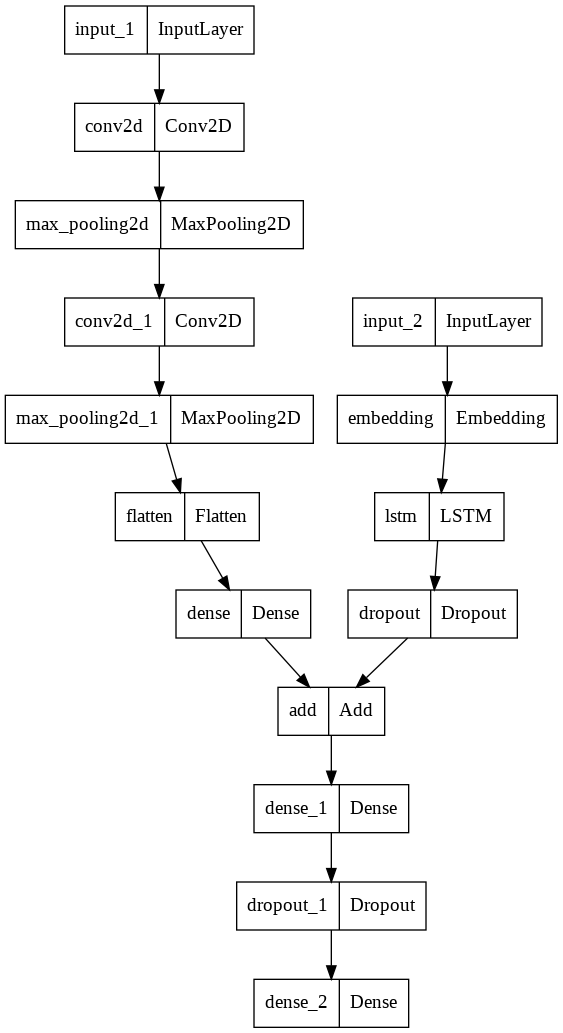

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit((train_feature, train_seq), train_y, epochs=32,
                    validation_data=((test_feature, test_seq), test_y))

Epoch 1/32
1410/1410 [==============================] - 525s 371ms/step - loss: 30.4032 - val_loss: 6.3045
Epoch 2/32
1410/1410 [==============================] - 526s 373ms/step - loss: 6.3401 - val_loss: 6.1331
Epoch 3/32
1410/1410 [==============================] - 526s 373ms/step - loss: 6.1869 - val_loss: 5.9649
Epoch 4/32
1410/1410 [==============================] - 535s 379ms/step - loss: 6.0519 - val_loss: 5.8110
Epoch 5/32
1410/1410 [==============================] - 535s 380ms/step - loss: 5.9158 - val_loss: 5.6502
Epoch 6/32
1410/1410 [==============================] - 557s 395ms/step - loss: 5.7762 - val_loss: 5.4871
Epoch 7/32
1410/1410 [==============================] - 533s 378ms/step - loss: 5.6443 - val_loss: 5.3496
Epoch 8/32
1410/1410 [==============================] - 539s 382ms/step - loss: 5.5209 - val_loss: 5.1841
Epoch 9/32
1410/1410 [==============================] - 530s 376ms/step - loss: 5.3995 - val_loss: 5.0761
Epoch 10/32
1410/1410 [======================

In [ ]:
def inverse_tokenizer(index):
    for word, i in tokenizer.word_index.items():
        if i==index:
            return word
    return None

In [ ]:
def evaluate_speech_to_text(audio_path):
    path = audio_path.split('/')[-1]
    feature = mfcc_features[path].reshape(-1, 16, 8, 1)
    pred_text = "start"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([pred_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        word = inverse_tokenizer(y_pred)
        if word is None:
            break
        pred_text+= " " + word
        if word == 'end':
            break
    return pred_text

In [ ]:
print(mfcc_features.keys())

dict_keys(['lupincontresholme_2419.wav', 'lesmis_1812.wav', 'lesmis_4924.wav', 'lesmis_4696.wav', 'lupincontresholme_1665.wav', 'lesmis_1751.wav', 'lupincontresholme_0833.wav', 'lupincontresholme_1598.wav', 'lesmis_1684.wav', 'lesmis_2135.wav', 'lupincontresholme_1314.wav', 'lesmis_2030.wav', 'lupincontresholme_0757.wav', 'lesmis_1221.wav', 'lesmis_2850.wav', 'lesmis_1834.wav', 'lesmis_2536.wav', 'lesmis_1045.wav', 'lupincontresholme_0957.wav', 'lesmis_3444.wav', 'lesmis_3252.wav', 'lupincontresholme_2069.wav', 'lesmis_5023.wav', 'lesmis_2842.wav', 'lupincontresholme_1167.wav', 'lesmis_0995.wav', 'lesmis_2918.wav', 'lesmis_4583.wav', 'lupincontresholme_0601.wav', 'lupincontresholme_0384.wav', 'lupincontresholme_0328.wav', 'lupincontresholme_0119.wav', 'lesmis_3201.wav', 'lesmis_5490.wav', 'lupincontresholme_0939.wav', 'lesmis_3992.wav', 'lesmis_4112.wav', 'lesmis_0894.wav', 'lesmis_0529.wav', 'lesmis_4508.wav', 'lupincontresholme_0533.wav', 'lupincontresholme_1420.wav', 'lupincontresho

In [ ]:
sample_df = train.sample(20)
files = sample_df['file'].tolist()
actual_transcription = sample_df['transcription'].tolist()
pred_transcription = []
for file in files:
    transcription = evaluate_speech_to_text(file)
    pred_transcription.append(transcription)

1/1 [==============================] - 0s 31ms/step


### Results

In [ ]:
print(wer(actual_transcription[2], pred_transcription[2] ,debug=True))

OP	REF	HYP
OK	start	start
DEL	je	****
DEL	t	****
DEL	assure	****
SUB	que	il
SUB	cela	se
SUB	t	retira
SUB	ennuiera	d
SUB	non	une
SUB	puisque	voix
SUB	c	de
SUB	est	crozon
SUB	vous	le
SUB	je	baron
SUB	ne	se
SUB	vous	retourna
SUB	comprendrai	de
SUB	pas	crozon
SUB	mais	le
SUB	je	baron
SUB	vous	se
SUB	couterai	retourna
OK	end	end
#cor 2
#sub 18
#del 3
#ins 0
{'WER': 0.913, 'numCor': 2, 'numSub': 18, 'numIns': 0, 'numDel': 3, 'numCount': 23}


In [ ]:
print(wers(actual_transcription, pred_transcription))

0.89
